In [1]:
import sys

sys.path.append("..")
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dory.classifier import (
    GaussianNaiveBayesClassifier,
    GaussianDiscriminatorAnalysisClassifier,
    LogisticRegressionClassifier,
)
from dory.cross_validators import DoryKFoldCrossValidator
import logging

logging.basicConfig(level=logging.INFO)

In [2]:
df = pd.read_csv("breastcancer.csv", header=None)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.372583
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,0.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [3]:
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42069
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(455, 30) (114, 30) (455,) (114,)


In [4]:
logger = logging.getLogger("CrossValidation")

classifiers = [
    ("Gaussian Naive Bayes", GaussianNaiveBayesClassifier()),
    ("Gaussian Discriminant Analysis", GaussianDiscriminatorAnalysisClassifier()),
    (
        "Logistic Regression",
        LogisticRegressionClassifier(learning_rate=0.01, epochs=1000),
    ),
]

results = {
    name: {
        "global_accuracy": [],
        "accuracy_per_class": [],
        "mean_global_accuracy": 0,
        "std_global_accuracy": 0,
        "mean_accuracy_per_class": {},
        "std_accuracy_per_class": {},
        "y_true_all": [],
        "y_pred_all": [],
    }
    for name, _ in classifiers
}

n_folds = 10
random_state = 42069

cv = DoryKFoldCrossValidator(n_splits=n_folds, random_state=random_state, shuffle=True)

for i, (train_index, test_index) in enumerate(cv.split(X)):
    logger.debug(f"Fold {i}:")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for name, clf in classifiers:
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        accuracy = clf.score(X_test, y_test)

        # Store predictions for later metric calculation
        results[name]["y_true_all"].extend(y_test)
        results[name]["y_pred_all"].extend(y_pred)

        accuracy_per_class = {clz: [] for clz in np.unique(y)}

        for clz in np.unique(y):
            y_test_clz = y_test[y_test == clz]
            y_pred_clz = clf.predict(X_test[y_test == clz])
            class_accuracy = np.mean(y_pred_clz == y_test_clz)

            accuracy_per_class[clz].append(class_accuracy)

        results[name]["accuracy_per_class"].append(accuracy_per_class)
        results[name]["global_accuracy"].append(accuracy)

        logger.debug(
            f"classifier {name}, Accuracy: {accuracy:.4f}, Accuracy per class: {accuracy_per_class}, Fold {i + 1}/{n_folds}"
        )


for name, _ in classifiers:
    global_accuracies = results[name]["global_accuracy"]
    mean_global_accuracy = np.mean(global_accuracies)
    std_global_accuracy = np.std(global_accuracies)

    results[name]["mean_global_accuracy"] = mean_global_accuracy
    results[name]["std_global_accuracy"] = std_global_accuracy

    logger.info(
        f"Classifier {name} - Global Accuracy: Mean={mean_global_accuracy:.4f}, Std={std_global_accuracy:.4f}"
    )

    accuracy_per_class = results[name]["accuracy_per_class"]
    mean_accuracy_per_class = {}
    std_accuracy_per_class = {}

    for clz in np.unique(y):
        class_accuracies = [fold_acc[clz][0] for fold_acc in accuracy_per_class]
        mean_accuracy_per_class[clz] = np.mean(class_accuracies)
        std_accuracy_per_class[clz] = np.std(class_accuracies)

    results[name]["mean_accuracy_per_class"] = mean_accuracy_per_class
    results[name]["std_accuracy_per_class"] = std_accuracy_per_class

    logger.info(
        f"Classifier {name} - Accuracy per class: Mean={mean_accuracy_per_class}, Std={std_accuracy_per_class}"
    )


/home/flemis/codes/dory/lista_02/../dory/classifier/logistic_regression.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/flemis/codes/dory/lista_02/../dory/classifier/logistic_regression.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/flemis/codes/dory/lista_02/../dory/classifier/logistic_regression.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/flemis/codes/dory/lista_02/../dory/classifier/logistic_regression.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/flemis/codes/dory/lista_02/../dory/classifier/logistic_regression.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/flemis/codes/dory/lista_02/../dory/classifier/logistic_regression.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/flemis/codes/dory/lista_02/../dory/classifier/logistic_regression.py:11: Run

In [5]:
# Calculate Precision, Recall, and F1 Score for each classifier
def calculate_precision_recall_f1(y_true, y_pred, pos_label=None):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # If pos_label not specified, use the second class (typical for binary classification)
    if pos_label is None:
        unique_classes = np.unique(y_true)
        pos_label = unique_classes[1] if len(unique_classes) > 1 else unique_classes[0]
    
    # True Positives, False Positives, False Negatives
    tp = np.sum((y_pred == pos_label) & (y_true == pos_label))
    fp = np.sum((y_pred == pos_label) & (y_true != pos_label))
    fn = np.sum((y_pred != pos_label) & (y_true == pos_label))
    
    # Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    
    # Recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    
    # F1 Score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return precision, recall, f1

# Calculate metrics for each classifier
metrics_comparison = []

for name, _ in classifiers:
    y_true = np.array(results[name]["y_true_all"])
    y_pred = np.array(results[name]["y_pred_all"])
    
    precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
    
    metrics_comparison.append({
        "Classificador": name,
        "Precision": f"{precision:.4f}",
        "Recall": f"{recall:.4f}",
        "F1-Score": f"{f1:.4f}",
    })

# Create comparison DataFrame
metrics_df = pd.DataFrame(metrics_comparison)
display(metrics_df)

,Classificador,Precision,Recall,F1-Score
0,Gaussian Naive Bayes,0.9272,0.9009,0.9139
1,Gaussian Discriminant Analysis,0.9898,0.9151,0.9510
2,Logistic Regression,0.3726,0.3392,0.3551


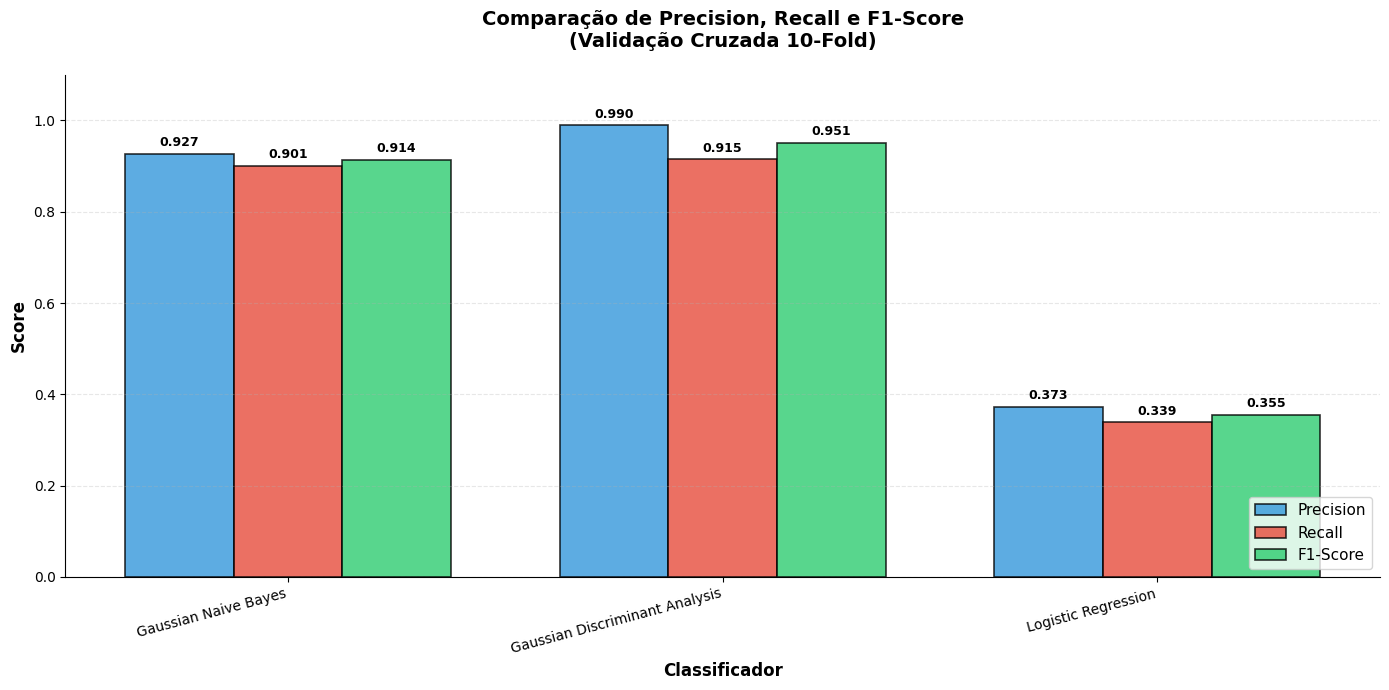

In [6]:
# Visualize Precision, Recall, and F1-Score comparison
fig, ax = plt.subplots(figsize=(14, 7))

classifier_names = [name for name, _ in classifiers]
metrics_names = ['Precision', 'Recall', 'F1-Score']

# Extract metric values
precision_values = []
recall_values = []
f1_values = []

for name, _ in classifiers:
    y_true = np.array(results[name]["y_true_all"])
    y_pred = np.array(results[name]["y_pred_all"])
    precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
    precision_values.append(precision)
    recall_values.append(recall)
    f1_values.append(f1)

x = np.arange(len(classifier_names))
width = 0.25

# Create bars
bars1 = ax.bar(x - width, precision_values, width, label='Precision', 
               color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.2)
bars2 = ax.bar(x, recall_values, width, label='Recall', 
               color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.2)
bars3 = ax.bar(x + width, f1_values, width, label='F1-Score', 
               color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=1.2)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_xlabel('Classificador', fontsize=12, fontweight='bold')
ax.set_title('Comparação de Precision, Recall e F1-Score\n(Validação Cruzada 10-Fold)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(classifier_names, rotation=15, ha='right')
ax.legend(loc='lower right', fontsize=11)
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [7]:
summary_data = []

class_mapper = {
    0.0: "Malignant",
    1.0: "Benign",
}

for name, _ in classifiers:
    row = {
        "Classificador": name,
        "Acurácia Global (Média)": f"{results[name]['mean_global_accuracy']:.4f}",
        "Acurácia Global (DP)": f"{results[name]['std_global_accuracy']:.4f}",
    }

    for clz in sorted(np.unique(y)):
        row[f"Classe {class_mapper[float(clz)]} (Média)"] = (
            f"{results[name]['mean_accuracy_per_class'][clz]:.4f}"
        )
        row[f"Classe {class_mapper[float(clz)]} (DP)"] = (
            f"{results[name]['std_accuracy_per_class'][clz]:.4f}"
        )

    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
display(summary_df)

,Classificador,Acurácia Global (Média),Acurácia Global (DP),Classe Malignant (Média),Classe Malignant (DP),Classe Benign (Média),Classe Benign (DP)
0,Gaussian Naive Bayes,0.9367,0.0386,0.9591,0.0325,0.8960,0.0697
1,Gaussian Discriminant Analysis,0.9648,0.0178,0.9941,0.0118,0.9162,0.0470
2,Logistic Regression,0.9069,0.0526,0.9536,0.0510,0.8327,0.1195


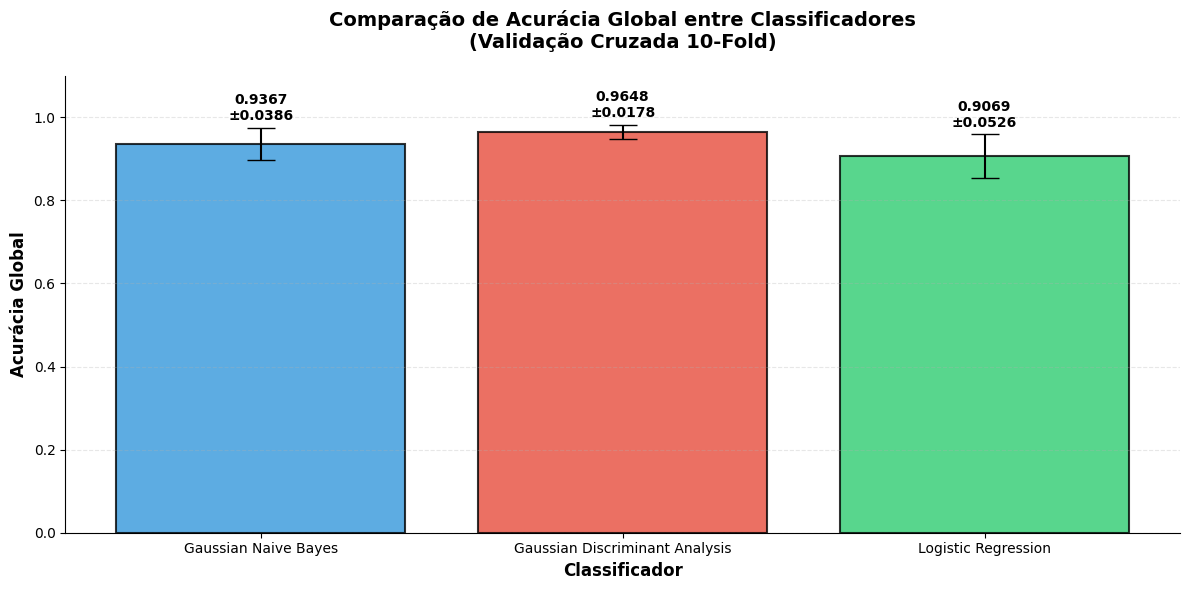

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))

classifier_names = [name for name, _ in classifiers]
means = [results[name]["mean_global_accuracy"] for name, _ in classifiers]
stds = [results[name]["std_global_accuracy"] for name, _ in classifiers]

colors = ["#3498db", "#e74c3c", "#2ecc71"]
bars = ax.bar(
    classifier_names,
    means,
    yerr=stds,
    capsize=10,
    color=colors,
    alpha=0.8,
    edgecolor="black",
    linewidth=1.5,
)

for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + std + 0.01,
        f"{mean:.4f}\n±{std:.4f}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

ax.set_ylabel("Acurácia Global", fontsize=12, fontweight="bold")
ax.set_xlabel("Classificador", fontsize=12, fontweight="bold")
ax.set_title(
    "Comparação de Acurácia Global entre Classificadores\n(Validação Cruzada 10-Fold)",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
ax.set_ylim(0, 1.1)
ax.grid(axis="y", alpha=0.3, linestyle="--")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

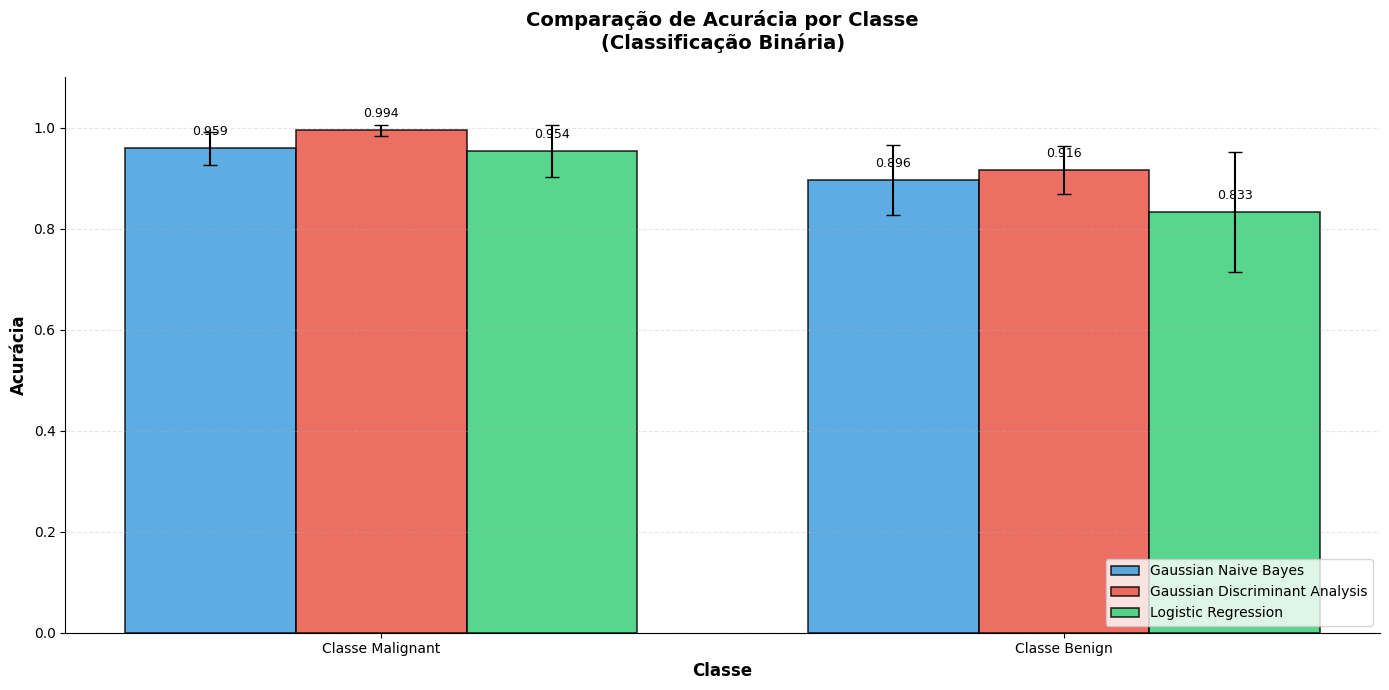

In [9]:
# 2. Gráfico de Barras Agrupadas - Acurácia por Classe
fig, ax = plt.subplots(figsize=(14, 7))

classes = sorted(np.unique(y))
x = np.arange(len(classes))
width = 0.25

for i, (name, _) in enumerate(classifiers):
    means_per_class = [results[name]["mean_accuracy_per_class"][clz] for clz in classes]
    stds_per_class = [results[name]["std_accuracy_per_class"][clz] for clz in classes]

    offset = (i - 1) * width
    bars = ax.bar(
        x + offset,
        means_per_class,
        width,
        yerr=stds_per_class,
        capsize=5,
        label=name,
        color=colors[i],
        alpha=0.8,
        edgecolor="black",
        linewidth=1.2,
    )

    # Adicionar valores nas barras
    for bar, mean in zip(bars, means_per_class):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.02,
            f"{mean:.3f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

ax.set_ylabel("Acurácia", fontsize=12, fontweight="bold")
ax.set_xlabel("Classe", fontsize=12, fontweight="bold")
ax.set_title(
    "Comparação de Acurácia por Classe\n(Classificação Binária)",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
ax.set_xticks(x)
ax.set_xticklabels([f"Classe {class_mapper[float(clz)]}" for clz in classes])
ax.legend(loc="lower right", fontsize=10)
ax.set_ylim(0, 1.1)
ax.grid(axis="y", alpha=0.3, linestyle="--")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()